# Sample usage

This notebook gives you introduction to use the package.

In [46]:
import sys
sys.path.append("../")
sys.path.append(".")
from model_criticism_mmd import ModelTrainerTorchBackend, MMD
from model_criticism_mmd.backends import kernels_torch

In [50]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import torch

# Device choice

If you are able to use CUDA, you can give `device_obj` to objects. The default value is CPU.

In [51]:
device_obj = torch.device('cpu')

# Scenario-1: 2 distributions are similar

In [32]:
x = np.random.normal(3, 0.5, size=(500, 2))
y = np.random.normal(3, 0.5, size=(500, 2))

In [40]:
df_x = pandas.DataFrame(x)
df_x['label'] = 'green'
df_y = pandas.DataFrame(y)
df_y['label'] = 'red'
df_data_scenario_1 = pandas.concat([df_x, df_y])
df_data_scenario_1.columns = ['dim0', 'dim1', 'label']

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

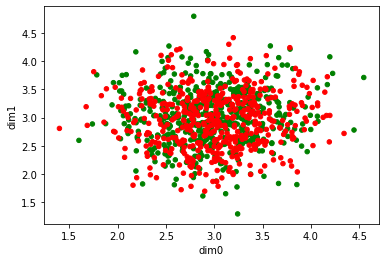

In [41]:
df_data_scenario_1.plot.scatter(x='dim0', y='dim1', c=df_data_scenario_1['label'])

In [42]:
n_train = 400
x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]

In [59]:
mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=True), device_obj=device_obj)
trainer = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator, device_obj=device_obj)
trained_obj = trainer.train(x_train, y_train, num_epochs=1000, batchsize=200)

input data N(sample-size)=400, N(dimension)=2
Validation at 0. MMD^2 = -0.00016274789749926022, obj-value = [1.62747897]
     5: avg train MMD^2 3.252995119706892e-05 obj [-0.32529951],  avg val MMD^2 -0.00019787549582539476  obj [1.97875496]  elapsed: 0.0
    25: avg train MMD^2 8.41393486328279e-07 obj [-0.00841393],  avg val MMD^2 -6.96230763737038e-05  obj [0.69623076]  elapsed: 0.0
    50: avg train MMD^2 4.5781885105178333e-07 obj [-0.00457819],  avg val MMD^2 -5.882201056084391e-05  obj [0.58822011]  elapsed: 0.0
   100: avg train MMD^2 3.863450420471537e-06 obj [-0.0386345],  avg val MMD^2 -4.649231318776259e-05  obj [0.46492313]  elapsed: 0.0
   200: avg train MMD^2 8.60081793107037e-05 obj [-0.40865048],  avg val MMD^2 -6.397962541360158e-05  obj [0.63979625]  elapsed: 0.0
   300: avg train MMD^2 2.4979655577905824e-05 obj [-0.21668309],  avg val MMD^2 -8.393753519309044e-05  obj [0.83937535]  elapsed: 0.0
   400: avg train MMD^2 3.208565849344147e-06 obj [-0.03208566],  avg 

In [60]:
trained_params = trained_obj.kernel_function_obj.get_params()
print(f'Preffered parameters scales = {trained_obj.scales}, {trained_params}')

Preffered parameters scales = [-1.0488653e-21 -1.2986040e+00], {'log_sigma': tensor([2.5993], requires_grad=True)}


In [61]:
mmd2, ratio = trainer.mmd_distance(x_test, y_test)
print(f'MMD^2 distance = {mmd2}')

MMD^2 distance = 4.008550016276757e-05


# Scenario-2: 2 distributions are not similar

In [62]:
x = np.random.normal(3, 0.5, size=(500, 2))
y = np.random.normal(10, 5.5, size=(500, 2))

In [63]:
df_x = pandas.DataFrame(x)
df_x['label'] = 'green'
df_y = pandas.DataFrame(y)
df_y['label'] = 'red'
df_data_scenario_1 = pandas.concat([df_x, df_y])
df_data_scenario_1.columns = ['dim0', 'dim1', 'label']

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

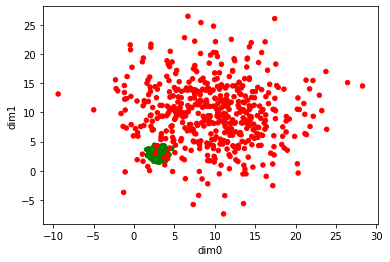

In [64]:
df_data_scenario_1.plot.scatter(x='dim0', y='dim1', c=df_data_scenario_1['label'])

In [65]:
n_train = 400
x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]

In [66]:
mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=True), device_obj=device_obj)
trainer = ModelTrainerTorchBackend(mmd_estimator, device_obj=device_obj)
trained_obj = trainer.train(x_train, y_train, num_epochs=1000, batchsize=200)

input data N(sample-size)=400, N(dimension)=2
Validation at 0. MMD^2 = 0.8540135763644832, obj-value = [-33.90760739]
     5: avg train MMD^2 0.8062308987762956 obj [-37.80603291],  avg val MMD^2 0.8647260061787395  obj [-49.62463833]  elapsed: 0.0
    25: avg train MMD^2 0.8230736811034356 obj [-37.27775957],  avg val MMD^2 0.8130697259975469  obj [-46.3108589]  elapsed: 0.0
    50: avg train MMD^2 0.8415626778435934 obj [-40.41469154],  avg val MMD^2 0.9108579331217165  obj [-46.76447806]  elapsed: 0.0
   100: avg train MMD^2 0.8003672662845188 obj [-38.95094163],  avg val MMD^2 0.8464993975391594  obj [-49.34959837]  elapsed: 0.0
   200: avg train MMD^2 0.8208940421730305 obj [-38.390754],  avg val MMD^2 0.7597058185985736  obj [-39.8364683]  elapsed: 0.0
   300: avg train MMD^2 0.8135335470013902 obj [-37.88106002],  avg val MMD^2 0.8184276865062196  obj [-46.83766978]  elapsed: 0.0
   400: avg train MMD^2 0.8148825528692156 obj [-38.04791343],  avg val MMD^2 0.7830441272161851  ob

In [67]:
trained_params = trained_obj.kernel_function_obj.get_params()
print(f'Preffered parameters scales = {trained_obj.scales} / {trained_params}')
mmd2, ratio = trainer.mmd_distance(x_test, y_test)
print(f'MMD^2 distance = {mmd2}')

Preffered parameters scales = [5.00481   4.4539423] / {'log_sigma': tensor([2.0128], requires_grad=True)}
MMD^2 distance = 0.8629173294051006


# Kernel functions

You can set kernel functions as you like. The Kernel functions are in `model_criticism_mmd.backends.kernels_torch`


In [87]:
from model_criticism_mmd.backends import kernels_torch
kernel_matern = kernels_torch.MaternKernelFunction(device_obj=device_obj, nu=0.5)
mmd_estimator_matern = MMD(kernel_matern, device_obj=device_obj)
trainer_matern = ModelTrainerTorchBackend(mmd_estimator, device_obj=device_obj)
trained_obj_matern = trainer_matern.train(x_train, y_train, num_epochs=1000, batchsize=200)

input data N(sample-size)=80, N(dimension)=3
Validation at 0. MMD^2 = 0.923964025530362, obj-value = [-32.78176678]
     5: avg train MMD^2 0.8812829048226111 obj [-19.97977788],  avg val MMD^2 0.9339892329656062  obj [-83.03206337]  elapsed: 0.0
    25: avg train MMD^2 0.9074581767852474 obj [-27.1110256],  avg val MMD^2 0.9246882955251008  obj [-63.95618979]  elapsed: 0.0
    50: avg train MMD^2 0.9182472808921586 obj [-34.09759982],  avg val MMD^2 0.9194518082438816  obj [-68.08686832]  elapsed: 0.0
   100: avg train MMD^2 0.9460862280304295 obj [-44.29575112],  avg val MMD^2 0.9457162983667037  obj [-101.79990004]  elapsed: 0.0
   200: avg train MMD^2 1.4969727397708684e-14 obj [-1.49697274e-10],  avg val MMD^2 0.0  obj [0.]  elapsed: 0.0
   300: avg train MMD^2 1.1564823173178714e-17 obj [-1.15648232e-13],  avg val MMD^2 0.0  obj [0.]  elapsed: 0.0
   400: avg train MMD^2 1.1564823173178714e-17 obj [-1.15648232e-13],  avg val MMD^2 0.0  obj [0.]  elapsed: 0.0
   500: avg train MMD

In [88]:
trained_obj_matern.scalesles

array([  220.34052, -1191.835  , -2792.913  ], dtype=float32)

As you see, the scales are totally different from the one with RBFKernel

# Scenario-3: ARD weight

As you see in data generation, the data has huge variance only on __the 1st dimension__.

Then, the ARD weight has the highest value on the 1st dimension.

Remebmer that you set __opt_sigma = False__ when you need ARD weights.

In [90]:
import numpy
size = 100
n_epoch = 500
batch_size = 200

x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:80]
y_train = y[:80]
x_val = x[80:]
y_val = y[80:]

In [91]:
for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for
dim_most_diff_varianace: int = sorted([(n_dim, abs(x[:,n_dim].var() - y[:,n_dim].var())) for n_dim in [0, 1, 2]],
                                      key=lambda t: t[1], reverse=True)[0][0]

1 dim. mean(x)=1.0 mean(y)=4.5527841124346615 var(x)=0.0 var(y)=2580.019069183424
2 dim. mean(x)=9.962903966576448 mean(y)=9.99608682497946 var(x)=0.04732657552745462 var(y)=0.048026469129746445
3 dim. mean(x)=10.010927261256287 mean(y)=9.985103474215355 var(x)=0.042078884303361125 var(y)=0.0416659000153722


In [92]:
mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=False), device_obj=device_obj)
trainer = ModelTrainerTorchBackend(mmd_estimator, device_obj=device_obj)
trained_obj = trainer.train(x_train, y_train, num_epochs=500, batchsize=200)

input data N(sample-size)=80, N(dimension)=3
Validation at 0. MMD^2 = 0.8678697269765652, obj-value = [-9.1494386]
     5: avg train MMD^2 0.9948316986662756 obj [-486.29887533],  avg val MMD^2 0.34997460689966925  obj [-4.98625238]  elapsed: 0.0
    25: avg train MMD^2 0.019154809383567274 obj [-5.96475219],  avg val MMD^2 0.026220343482805605  obj [-2.66847509]  elapsed: 0.0
    50: avg train MMD^2 0.015158244921328261 obj [-5.76282363],  avg val MMD^2 0.02245991475381181  obj [-2.53953584]  elapsed: 0.0
   100: avg train MMD^2 0.015121417967994117 obj [-5.76125544],  avg val MMD^2 0.022448451608607072  obj [-2.5396787]  elapsed: 0.0
   200: avg train MMD^2 0.01559135249365684 obj [-5.79201131],  avg val MMD^2 0.022968583402313926  obj [-2.56135902]  elapsed: 0.0
   300: avg train MMD^2 0.01607463816540656 obj [-5.82139212],  avg val MMD^2 0.023497328252830553  obj [-2.58232405]  elapsed: 0.0
   400: avg train MMD^2 0.01657137838654462 obj [-5.84941954],  avg val MMD^2 0.024034906795

In [93]:
assert np.argmax(trained_obj.scales) == dim_most_diff_varianace
trained_obj.scales

array([ 46.32331 , -17.280907, -31.993467], dtype=float32)

As you see, the index of max(scales) is same as the index that data has the highest variance.